# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [205]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
offers = pd.read_json('data/portfolio.json', orient='records', lines=True)
customers = pd.read_json('data/profile.json', orient='records', lines=True)
actions = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploring offers/discounts
rows, columns, columns name, nullity

In [206]:
print(offers.shape)
print(offers.columns)
offers

(10, 6)
Index(['channels', 'difficulty', 'duration', 'id', 'offer_type', 'reward'], dtype='object')


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [207]:
offers.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

### One hot encoding of channels/

In [208]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
offers = offers.join(pd.DataFrame(mlb.fit_transform(offers.pop('channels')),
                          columns=mlb.classes_,
                          index=offers.index))

In [209]:
offers.columns = ['difficulty', 'duration', 'id', 'offer_type', 'offer_reward', 'email',
       'mobile', 'social', 'web']

In [210]:
offers

,difficulty,duration,id,offer_type,offer_reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


## Exploring customers and changing became_member_on to date time
rows, columns, columns name, nullity


In [211]:
print(customers.shape)
print(customers.columns)
customers.head()

(17000, 5)
Index(['age', 'became_member_on', 'gender', 'id', 'income'], dtype='object')


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [212]:
customers.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [213]:
customers['became_member_on']=pd.to_datetime(customers.became_member_on,format = "%Y%m%d")

### Note that the following implies those without gender data will have no income data too
Probably this just mean the customer data is private, if they do not share their gender data, they will not share their income data too  

In [214]:
customers.isna().sum(axis=1).value_counts()

0    14825
2     2175
dtype: int64

In [215]:
2175/(14825+2175) #12% of data is private

0.12794117647058822

In [216]:
customers.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


The data looks dubious, having people of age 118, let's take a look at what proportion of people are at age 118

In [217]:
customers.age[customers.age>100].value_counts()

118    2175
101       5
Name: age, dtype: int64

In [218]:
118/17000*100 ## 0.694%, not a very likely number, we will drop off these anomally.

0.6941176470588235

In [219]:
customers = customers[customers.age<118].reset_index(drop=True)

In [220]:
customers.describe()

,age,income
count,14825.000000,14825.000000
mean,54.393524,65404.991568
std,17.383705,21598.299410
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


Stats looks more pleasant now with max age 101

In [221]:
customers.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

By removing people of age 118, all NA data miraculiously became missing. looks like 2175 people of age 118 correspond with those with no gender and income

In [222]:
customers = customers[customers.gender != 'O']

## Exploring actions
row,columns, column names, nullity

In [223]:
print(actions.shape)
print(actions.columns)
actions.tail()

(306534, 4)
Index(['event', 'person', 'time', 'value'], dtype='object')


,event,person,time,value
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [224]:
actions['time'] = np.ceil(actions.time/24)

In [225]:
actions.isna().sum() ##No nullity, that's good quality data

event     0
person    0
time      0
value     0
dtype: int64

In [226]:
actions.event.value_counts() ## We can see events are split into four types.

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [227]:
from pandas.io.json import json_normalize
temp = json_normalize(actions['value']) ## note that "offer id" comes from offer received and viewed, while offer_id comes from offer completed
temp.head()

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


we note that there's offer id and offer_id, we try to combine this into 1 column, we first check whether are they simultaneously populated

In [228]:
temp[['offer id','offer_id']].isna().sum(axis=1).value_counts() ## not that either both are NA or one of them is NA, so we can combine both columns

1    167581
2    138953
dtype: int64

#### We combine offer id and offer_id and delete offer id

In [229]:
temp['offer_id']= temp['offer_id'].fillna(temp['offer id'])

In [230]:
del temp['offer id']

In [231]:
len(temp)

306534

## joining temp back to main table
concat rowwise

In [232]:
events = pd.concat([actions,temp],axis=1)

In [233]:
del events['value']

In [234]:
events.tail()

,event,person,time,amount,offer_id,reward
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,30.0,1.59,NaN,NaN
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,30.0,9.53,NaN,NaN
306531,transaction,a00058cf10334a308c68e7631c529907,30.0,3.61,NaN,NaN
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,30.0,3.53,NaN,NaN
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,30.0,4.05,NaN,NaN


## Data Analysis on customer profile

In [235]:
customers.head()

,age,became_member_on,gender,id,income
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [236]:
customers.describe()

,age,income
count,14613.000000,14613.000000
mean,54.393417,65435.707931
std,17.400201,21633.524110
min,18.000000,30000.000000
25%,42.000000,49000.000000
50%,55.000000,64000.000000
75%,66.000000,80000.000000
max,101.000000,120000.000000


Text(0.5,1,'Customer Age')

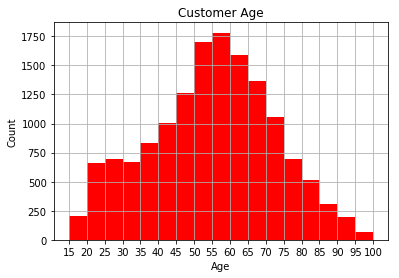

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns

customers.age.hist(bins=np.arange(15,105,5),color = 'red')
plt.xticks(range(15,105,5))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Customer Age')

#### Conclusion Customer Age
Normally distributed with mean 55-60  
looks like old people likes starbucks

Text(0.5,1,'Customer Annual Income')

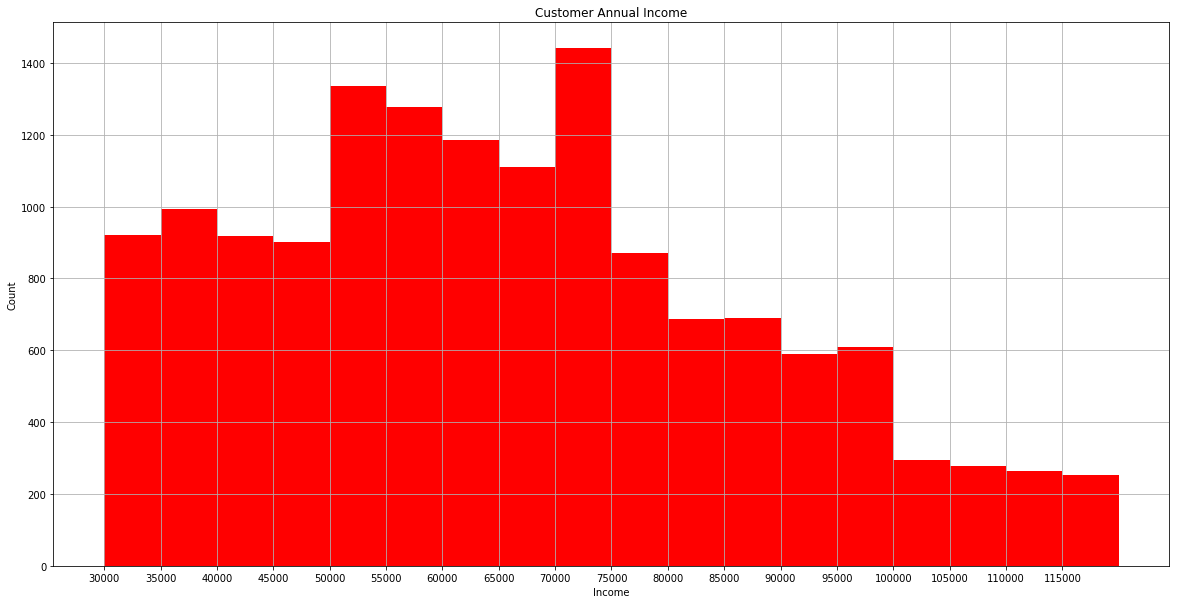

In [238]:
plt.figure(figsize=(20,10))
customers.income.hist(bins=18,color = 'red')
plt.xticks(range(30000,120000,5000))
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Customer Annual Income')

#### Conclusion Annual Income
People who buy starbucks are not rich people, they range mostly between 30k income to 75k income.

In [239]:
customers.gender.value_counts()

M    8484
F    6129
Name: gender, dtype: int64

Text(0.5,1,'Gender distribution')

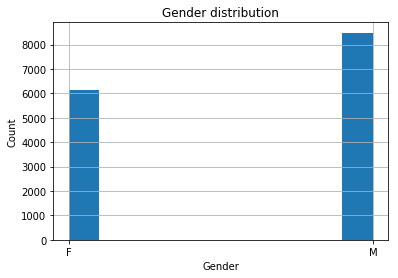

In [240]:
customers.gender.hist()
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender distribution')

#### Conclusion Gender
there are more male customers compared to female customers

In [241]:
customers.became_member_on.dt.year.value_counts()

2017    5510
2018    3614
2016    2992
2015    1568
2014     658
2013     271
Name: became_member_on, dtype: int64

Text(0.5,1,'Membership subscription distribution')

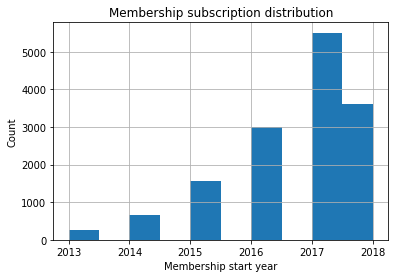

In [242]:
customers.became_member_on.dt.year.hist()
plt.xlabel('Membership start year')
plt.ylabel('Count')
plt.title('Membership subscription distribution')

In [243]:
max(customers.became_member_on)

Timestamp('2018-07-26 00:00:00')

In [244]:
min(customers.became_member_on)

Timestamp('2013-07-29 00:00:00')

Text(0.5,1,'Membership monthly subscription distribution')

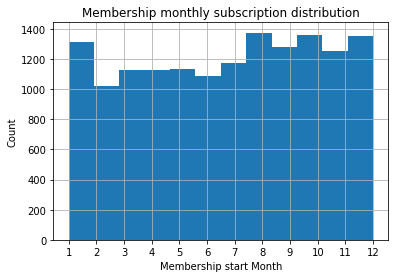

In [245]:
customers.became_member_on.dt.month.hist(bins=12)
plt.xticks(range(1,13))
plt.xlabel('Membership start Month')
plt.ylabel('Count')
plt.title('Membership monthly subscription distribution')

#### Conclusion: Membership
For Annual membership there's a year on year increase. We can't conclude for 2018 yet because the max data point is July 2018  
We can also see there's no visible seasonal trend for monthly data

## Combining all data together

In [246]:
events.tail()

,event,person,time,amount,offer_id,reward
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,30.0,1.59,NaN,NaN
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,30.0,9.53,NaN,NaN
306531,transaction,a00058cf10334a308c68e7631c529907,30.0,3.61,NaN,NaN
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,30.0,3.53,NaN,NaN
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,30.0,4.05,NaN,NaN


In [247]:
customers.columns

Index(['age', 'became_member_on', 'gender', 'id', 'income'], dtype='object')

In [248]:
offers.columns

Index(['difficulty', 'duration', 'id', 'offer_type', 'offer_reward', 'email',
       'mobile', 'social', 'web'],
      dtype='object')

events will be the main table, we will perform a left join with customers and offer_id

In [249]:
df = pd.merge(events,customers,left_on = 'person',right_on='id',how ='left')
df.drop(columns='id',inplace=True)

In [250]:
df = pd.merge(df,offers,left_on = 'offer_id',right_on='id',how='left')
df.drop(columns='id',inplace=True)

In [251]:
df.dropna(subset=['age'],inplace=True)

In [252]:
df.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [253]:
df[df.event=='offer completed']

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,offer_reward,email,mobile,social,web
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,42.0,2016-01-17,M,96000.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,39.0,2017-12-17,F,67000.0,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,52.0,2018-06-05,M,72000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0,37.0,2017-05-15,M,92000.0,10.0,7.0,bogo,10.0,1.0,1.0,1.0,0.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,48.0,2015-09-03,M,62000.0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0
12717,offer completed,227f2d69e46a4899b70d48182822cff6,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,51.0,2018-05-12,M,100000.0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0
12721,offer completed,bb0f25e23a4c4de6a645527c275cd594,0.0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,56.0,2014-06-11,M,76000.0,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0
12744,offer completed,d72d201be5794279aa716d8ad82b8d90,0.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5.0,51.0,2016-02-23,F,73000.0,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
12764,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,67.0,2015-09-29,F,67000.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
12767,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,59.0,2017-08-16,F,90000.0,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [254]:
df.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,offer_reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,2018-02-09,M,53000.0,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,58.0,2017-11-11,M,51000.0,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,61.0,2017-09-11,F,57000.0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0


## Data Analysis on combined Dataframe

Text(0.5,1,'offer gender distribution')

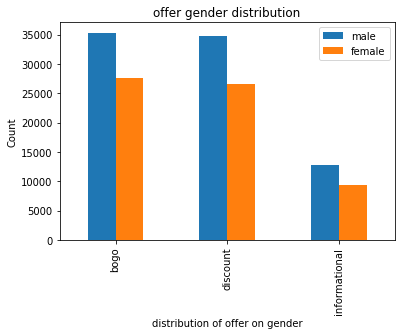

In [255]:
pd.DataFrame({'male':df[df.gender=="M"]["offer_type"].value_counts(),'female':df[df.gender=="F"]["offer_type"].value_counts()}).plot.bar()
plt.xlabel('distribution of offer on gender')
plt.ylabel('Count')
plt.title('offer gender distribution')

Text(0.5,1,'offer gender distribution 2')

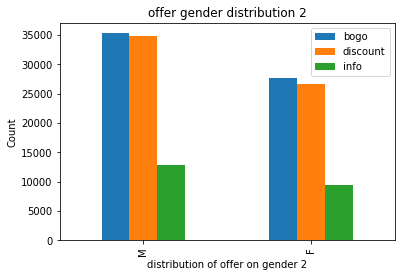

In [256]:
pd.DataFrame({'bogo':df[df.offer_type=="bogo"].gender.value_counts(),'discount':df[df.offer_type=="discount"].gender.value_counts(),'info':df[df.offer_type=="informational"].gender.value_counts()}).plot.bar()
plt.xlabel('distribution of offer on gender 2')
plt.ylabel('Count')
plt.title('offer gender distribution 2')

### Conclusion: Gender and offer_type demographic
the distribution is similar in both males and females

In [257]:
df.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,offer_reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,65.0,2018-02-09,M,53000.0,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,58.0,2017-11-11,M,51000.0,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,61.0,2017-09-11,F,57000.0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0


In [258]:
transaction_df = df[df.event=='transaction']
df = df[df.event!='transaction']

In [259]:
transaction_df.tail()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,offer_reward,email,mobile,social,web
306526,transaction,24f56b5e1849462093931b164eb803b5,30.0,22.64,NaN,NaN,48.0,2017-12-28,F,80000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,30.0,1.59,NaN,NaN,66.0,2018-01-01,M,47000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,30.0,9.53,NaN,NaN,52.0,2018-04-08,M,62000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,transaction,a00058cf10334a308c68e7631c529907,30.0,3.61,NaN,NaN,63.0,2013-09-22,F,52000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,30.0,3.53,NaN,NaN,57.0,2016-07-09,M,40000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## average spending of a person

Text(0.5,1,'spending per pax')

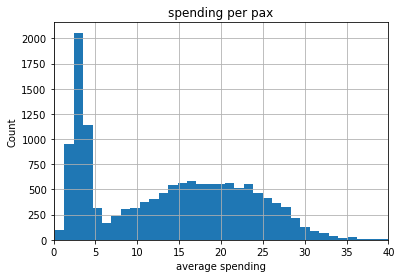

In [260]:
transaction_df.groupby("person")['amount'].mean().hist(bins =400)
ax = plt.gca()
ax.set_xlim(0,40)
plt.xlabel('average spending')
plt.ylabel('Count')
plt.title('spending per pax')

## Total Spending of a person

Text(0.5,1,'total spending per pax per month')

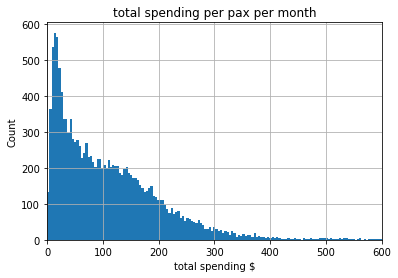

In [261]:
transaction_df.groupby("person")['amount'].sum().hist(bins =400)
ax = plt.gca()
ax.set_xlim(0,600)
plt.xlabel('total spending $')
plt.ylabel('Count')
plt.title('total spending per pax per month')

## Investigating which group of people response most to BOGO

In [269]:
df[df.offer_type == 'bogo'].event.value_counts()

offer received     26183
offer viewed       21724
offer completed    15013
Name: event, dtype: int64

In [270]:
df[df.offer_type == 'discount'].event.value_counts()

offer received     26297
offer viewed       18164
offer completed    16930
Name: event, dtype: int64

In [271]:
print('current bogo conversion rate {}'.format(15013/26183))
print('current discount conversion rate {}'.format(16930/26297))

current bogo conversion rate 0.5733873123782607
current discount conversion rate 0.6437996729664981


In [272]:
df.reset_index(inplace=True)

In [273]:
df.event.unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [274]:
df.head(2)

,index,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,offer_reward,email,mobile,social,web
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,2,offer received,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0


In [275]:
test = df.copy()

In [276]:
test = test.groupby(['person','offer_type','event'])['index'].count().unstack(level=1).unstack()

In [277]:
test.head()

offer_type                                  bogo                              \
event                            offer completed offer received offer viewed   
person                                                                         
0009655768c64bdeb2e877511632db8f             1.0            1.0          1.0   
0020c2b971eb4e9188eac86d93036a77             1.0            2.0          1.0   
0020ccbbb6d84e358d3414a3ff76cffd             2.0            2.0          2.0   
003d66b6608740288d6cc97a6903f4f0             NaN            NaN          NaN   
00426fe3ffde4c6b9cb9ad6d077a13ea             NaN            NaN          NaN   

offer_type                              discount                              \
event                            offer completed offer received offer viewed   
person                                                                         
0009655768c64bdeb2e877511632db8f             2.0            2.0          1.0   
0020c2b971eb4e9188eac86d93036a77             2.0            2.0          1.0   
0020ccbbb6d84e358d3414a3ff76cffd             1.0            1.0          1.0   
003d66b6608740288d6cc97a6903f4f0             3.0            3.0          2.0   
00426fe3ffde4c6b9cb9ad6d077a13ea             1.0            4.0          1.0   

offer_type                         informational                              
event                            offer completed offer received offer viewed  
person                                                                        
0009655768c64bdeb2e877511632db8f             NaN            2.0          2.0  
0020c2b971eb4e9188eac86d93036a77             NaN            1.0          1.0  
0020ccbbb6d84e358d3414a3ff76cffd             NaN            1.0          1.0  
003d66b6608740288d6cc97a6903f4f0             NaN            2.0          2.0  
00426fe3ffde4c6b9cb9ad6d077a13ea             NaN            1.0          1.0

In [278]:
test.columns

MultiIndex(levels=[['bogo', 'discount', 'informational'], ['offer completed', 'offer received', 'offer viewed']],
           labels=[[0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]],
           names=['offer_type', 'event'])

In [279]:
test.columns = ['_'.join(col) for col in test.columns]

In [280]:
test.drop(columns= ['informational_offer completed',"informational_offer received","informational_offer viewed"],inplace=True)

In [281]:
test.head()

,bogo_offer completed,bogo_offer received,bogo_offer viewed,discount_offer completed,discount_offer received,discount_offer viewed
person,,,,,,
0009655768c64bdeb2e877511632db8f,1.0,1.0,1.0,2.0,2.0,1.0
0020c2b971eb4e9188eac86d93036a77,1.0,2.0,1.0,2.0,2.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,2.0,2.0,2.0,1.0,1.0,1.0
003d66b6608740288d6cc97a6903f4f0,NaN,NaN,NaN,3.0,3.0,2.0
00426fe3ffde4c6b9cb9ad6d077a13ea,NaN,NaN,NaN,1.0,4.0,1.0


In [282]:
df.head(2)

,index,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,difficulty,duration,offer_type,offer_reward,email,mobile,social,web
0,0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,2,offer received,e2127556f4f64592b11af22de27a7932,0.0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,10.0,7.0,discount,2.0,1.0,1.0,0.0,1.0


In [283]:
df = df.groupby('person').agg({'age':"first","became_member_on":"first","gender":"first","income":"first"})

In [284]:
df = pd.merge(df,test, on = 'person',how = 'left')

In [285]:
df.head(3)

,age,became_member_on,gender,income,bogo_offer completed,bogo_offer received,bogo_offer viewed,discount_offer completed,discount_offer received,discount_offer viewed
person,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,33.0,2017-04-21,M,72000.0,1.0,1.0,1.0,2.0,2.0,1.0
0020c2b971eb4e9188eac86d93036a77,59.0,2016-03-04,F,90000.0,1.0,2.0,1.0,2.0,2.0,1.0
0020ccbbb6d84e358d3414a3ff76cffd,24.0,2016-11-11,F,60000.0,2.0,2.0,2.0,1.0,1.0,1.0


In [286]:
df['bogo_view_rate'] = df['bogo_offer viewed']/df['bogo_offer received']*100
df['bogo_com_rate'] = df['bogo_offer completed']/df['bogo_offer received']*100
df['dis_view_rate'] = df['discount_offer viewed']/df['discount_offer received']*100
df['dis_com_rate'] = df['discount_offer completed']/df['discount_offer received']*100

In [287]:
df.drop(columns= ['bogo_offer viewed','bogo_offer completed','discount_offer viewed','discount_offer completed'],inplace=True)

In [288]:
df.columns = ['age', 'member_start', 'gender', 'income', 'bogo_offer_rec',
       'dis_offer_rec', 'bogo_view_rate', 'bogo_com_rate',
       'dis_view_rate', 'dis_com_rate']

In [289]:
df['mem_year']=df.member_start.dt.year

## Creating labels
We define an offer(bogo or discount) as successful if viewrate>70% and success rate is more than 70%

In [290]:
df['bogo_success'] = (df.bogo_view_rate>70) & (df.bogo_com_rate>70)
df['dis_success'] = (df.dis_view_rate>70) & (df.dis_com_rate>70)

In [315]:
print(df.bogo_success.sum())
df.bogo_success.mean()

4848


0.33187294633077763

In [314]:
print(df.dis_success.sum())
print(df.dis_success.mean())

4898
0.335295728368


### Benchmark
The current benchmark for bogo_success is 33.187%  
the current benchmark for dis_success is 33.529%

In [292]:
df.head(10)

,age,member_start,gender,income,bogo_offer_rec,dis_offer_rec,bogo_view_rate,bogo_com_rate,dis_view_rate,dis_com_rate,mem_year,bogo_success,dis_success
person,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,33.0,2017-04-21,M,72000.0,1.0,2.0,100.000000,100.0,50.000000,100.0,2017,True,False
0020c2b971eb4e9188eac86d93036a77,59.0,2016-03-04,F,90000.0,2.0,2.0,50.000000,50.0,50.000000,100.0,2016,False,False
0020ccbbb6d84e358d3414a3ff76cffd,24.0,2016-11-11,F,60000.0,2.0,1.0,100.000000,100.0,100.000000,100.0,2016,True,True
003d66b6608740288d6cc97a6903f4f0,26.0,2017-06-21,F,73000.0,NaN,3.0,NaN,NaN,66.666667,100.0,2017,False,False
00426fe3ffde4c6b9cb9ad6d077a13ea,19.0,2016-08-09,F,65000.0,NaN,4.0,NaN,NaN,25.000000,25.0,2016,False,False
004b041fbfe44859945daa2c7f79ee64,55.0,2018-05-08,F,74000.0,1.0,1.0,100.000000,100.0,100.000000,100.0,2018,True,True
004c5799adbf42868b9cff0396190900,54.0,2016-03-31,M,99000.0,3.0,2.0,66.666667,100.0,100.000000,100.0,2016,False,True
005500a7188546ff8a767329a2f7c76a,56.0,2017-12-09,M,47000.0,4.0,1.0,75.000000,25.0,NaN,NaN,2017,False,False
0056df74b63b4298809f0b375a304cf4,54.0,2016-08-21,M,91000.0,1.0,2.0,100.000000,100.0,50.000000,100.0,2016,True,False


## Get ready the data for training

In [293]:
ready=df.reset_index()[['age','mem_year','gender','income','bogo_offer_rec','dis_offer_rec','bogo_success','dis_success']]

In [294]:
ready.head()

,age,mem_year,gender,income,bogo_offer_rec,dis_offer_rec,bogo_success,dis_success
0,33.0,2017,M,72000.0,1.0,2.0,True,False
1,59.0,2016,F,90000.0,2.0,2.0,False,False
2,24.0,2016,F,60000.0,2.0,1.0,True,True
3,26.0,2017,F,73000.0,NaN,3.0,False,False
4,19.0,2016,F,65000.0,NaN,4.0,False,False


### One hot encoding for categorical data

In [295]:
ready['isMale']=ready['gender'].map({"M":1,'F':0})
# ready = pd.concat([ready,pd.get_dummies(data=ready.mem_year, drop_first=True)],axis=1)

In [296]:
ready[['age','bogo_success','dis_success']] = ready[['age','bogo_success','dis_success']].astype('int')

In [297]:
ready.dtypes

age                 int64
mem_year            int64
gender             object
income            float64
bogo_offer_rec    float64
dis_offer_rec     float64
bogo_success        int64
dis_success         int64
isMale              int64
dtype: object

In [298]:
ready.head(10)

,age,mem_year,gender,income,bogo_offer_rec,dis_offer_rec,bogo_success,dis_success,isMale
0,33,2017,M,72000.0,1.0,2.0,1,0,1
1,59,2016,F,90000.0,2.0,2.0,0,0,0
2,24,2016,F,60000.0,2.0,1.0,1,1,0
3,26,2017,F,73000.0,NaN,3.0,0,0,0
4,19,2016,F,65000.0,NaN,4.0,0,0,0
5,55,2018,F,74000.0,1.0,1.0,1,1,0
6,54,2016,M,99000.0,3.0,2.0,0,1,1
7,56,2017,M,47000.0,4.0,1.0,0,0,1
8,54,2016,M,91000.0,1.0,2.0,1,0,1
9,58,2017,F,119000.0,2.0,3.0,0,0,0


In [299]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
bogo_X = np.squeeze(ready[ready.bogo_offer_rec>0][['age','mem_year','isMale','income']].values)
dis_X = np.squeeze(ready[ready.dis_offer_rec>0][['age','mem_year','isMale','income']].values)
bogo_Y = np.squeeze(ready[ready.bogo_offer_rec>0][['bogo_success']].values)
dis_Y = np.squeeze(ready[ready.dis_offer_rec>0][['dis_success']].values)

bogo_X_train, bogo_X_test, bogo_Y_train, bogo_Y_test = train_test_split(bogo_X, bogo_Y, test_size = .20, random_state = 9)
dis_X_train, dis_X_test, dis_Y_train, dis_Y_test = train_test_split(dis_X, dis_Y, test_size = .20, random_state = 9)

### Model 1: Logistic Regression

In [300]:
bogo_1 = linear_model.LogisticRegression()
dis_1 = linear_model.LogisticRegression()
bogo_1.fit(bogo_X_train, bogo_Y_train)
dis_1.fit(dis_X_train, dis_Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [301]:
print('Bogo train F1_score {}'.format( bogo_1.score(bogo_X_train,bogo_Y_train)))
print('Bogo Test F1_score {}'.format(bogo_1.score(bogo_X_test,bogo_Y_test)))
print('Discount train F1_score {}'.format(dis_1.score(dis_X_train,dis_Y_train)))
print('Discount test Test F1_score {}'.format(dis_1.score(dis_X_test,dis_Y_test)))

Bogo train F1_score 0.6175387596899224
Bogo Test F1_score 0.6178294573643411
Discount train F1_score 0.6088478366553233
Discount test Test F1_score 0.5905909797822706


### Model 2: KNN

In [303]:
from sklearn.neighbors import KNeighborsClassifier
bogo_2 = KNeighborsClassifier()
dis_2 = KNeighborsClassifier()
bogo_2.fit(bogo_X_train, bogo_Y_train)
dis_2.fit(dis_X_train, dis_Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [304]:
print('Bogo train F1_score {}'.format( bogo_2.score(bogo_X_train,bogo_Y_train)))
print('Bogo Test F1_score {}'.format(bogo_2.score(bogo_X_test,bogo_Y_test)))
print('Discount train F1_score {}'.format(dis_2.score(dis_X_train,dis_Y_train)))
print('Discount test Test F1_score {}'.format(dis_2.score(dis_X_test,dis_Y_test)))

Bogo train F1_score 0.7410852713178294
Bogo Test F1_score 0.5906976744186047
Discount train F1_score 0.7271754982984929
Discount test Test F1_score 0.5987558320373251


### Model 3: GaussianNB

In [305]:
from sklearn.naive_bayes import GaussianNB
bogo_3 = GaussianNB()
dis_3 = GaussianNB()
bogo_3.fit(bogo_X_train, bogo_Y_train)
dis_3.fit(dis_X_train, dis_Y_train)

GaussianNB(priors=None)

In [306]:
print('Bogo train F1_score {}'.format( bogo_3.score(bogo_X_train,bogo_Y_train)))
print('Bogo Test F1_score {}'.format(bogo_3.score(bogo_X_test,bogo_Y_test)))
print('Discount train F1_score {}'.format(dis_3.score(dis_X_train,dis_Y_train)))
print('Discount test Test F1_score {}'.format(dis_3.score(dis_X_test,dis_Y_test)))

Bogo train F1_score 0.6400193798449613
Bogo Test F1_score 0.6372093023255814
Discount train F1_score 0.6235294117647059
Discount test Test F1_score 0.6298600311041991


### Model 4: SVC

In [307]:
from sklearn.svm import SVC
bogo_4 = SVC()
dis_4 = SVC()
bogo_4.fit(bogo_X_train, bogo_Y_train)
dis_4.fit(dis_X_train, dis_Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [308]:
print('Bogo train F1_score {}'.format(bogo_4.score(bogo_X_train,bogo_Y_train)))
print('Bogo Test F1_score {}'.format(bogo_4.score(bogo_X_test,bogo_Y_test)))
print('Discount train F1_score {}'.format(dis_4.score(dis_X_train,dis_Y_train)))
print('Discount test Test F1_score {}'.format(dis_4.score(dis_X_test,dis_Y_test)))

Bogo train F1_score 0.811531007751938
Bogo Test F1_score 0.6065891472868217
Discount train F1_score 0.8073894020418084
Discount test Test F1_score 0.604199066874028


### Model 5: Ada Boost

In [309]:
from sklearn.ensemble import AdaBoostClassifier
bogo_5 = AdaBoostClassifier()
dis_5 = AdaBoostClassifier()
bogo_5.fit(bogo_X_train, bogo_Y_train)
dis_5.fit(dis_X_train, dis_Y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [310]:
print('Bogo train F1_score {}'.format(bogo_5.score(bogo_X_train,bogo_Y_train)))
print('Bogo Test F1_score {}'.format(bogo_5.score(bogo_X_test,bogo_Y_test)))
print('Discount train F1_score {}'.format(dis_5.score(dis_X_train,dis_Y_train)))
print('Discount test Test F1_score {}'.format(dis_5.score(dis_X_test,dis_Y_test)))

Bogo train F1_score 0.6736434108527132
Bogo Test F1_score 0.6593023255813953
Discount train F1_score 0.6516285853184249
Discount test Test F1_score 0.6590202177293935


# Conclusion
Using Model 5 is the best option with F1 score of almost 66%.  
To predict whether is the starbucks member receptive of bogo or discount, we need certain details (age, membership starting date, gender and annual income)  

We place this into our model, bogo_5 and dis_5  
if both returns 1, the customer is receptive to both  
else it is receptive to either bogo or discount or none.

All 5 of the models beat the benchmark(33%) significantly. The best model(ada boost) on testing set has a f1 score of around 66%, which is a high score